<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 105</h1>
<h1>The Impact of Competing Strains</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

import tqdm as tq
from tqdm.notebook import tqdm

import epidemik
from epidemik import EpiModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 6f3f47aa98b5141fcddbadd07afeedaa91c4cfb7

cartopy   : 0.22.0
numpy     : 1.26.4
tqdm      : 4.66.2
pandas    : 2.1.4
matplotlib: 3.8.0
watermark : 2.4.3
epidemik  : 0.0.11



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## CoVID19 Model

We start by reintroducing the SEIIRD model as it contains enough features to be (somewhat) realistic while still being relatively simple to understand

In [4]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0

beta = R0*mu/(pa*rbeta+(1-pa))

SEIIRD = EpiModel()
SEIIRD.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIRD.add_interaction('S', 'E', 'Is', beta)
SEIIRD.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIRD.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIRD.add_spontaneous('Ia', 'R', mu)
SEIIRD.add_spontaneous('Is', 'R', (1-pD)*mu)
SEIIRD.add_spontaneous('Is', 'D', pD*mu)

The model contains 7 different transitions across 6 compartments:

In [5]:
print(SEIIRD)

Epidemic Model with 6 compartments and 7 transitions:

S + Ia = E 0.166667
S + Is = E 0.222222
E -> Ia 0.160000
E -> Is 0.240000
Ia -> R 0.100000
Is -> R 0.090000
Is -> D 0.010000

R0=2.00


Define our initial population

In [6]:
N = 100000
I0 = 10

And integrate the model. This will be our baseline model. For the sake of simplicity we don't worry about seasonal effects as those would affect both strains equally

In [7]:
SEIIRD.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
original = SEIIRD.values_.copy()

Now we compute the timeline of the new strain with a value of $R_0$ higher by 0.7

In [8]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.7

beta = R0*mu/(pa*rbeta+(1-pa))

SEIIRD2 = EpiModel()
SEIIRD2.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIRD2.add_interaction('S', 'E', 'Is', beta)
SEIIRD2.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIRD2.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIRD2.add_spontaneous('Ia', 'R', mu)
SEIIRD2.add_spontaneous('Is', 'R', (1-pD)*mu)
SEIIRD2.add_spontaneous('Is', 'D', pD*mu)

In [9]:
SEIIRD2.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
UK = SEIIRD2.values_.copy()

When we plot them side by side, the difference is clear. The higher $R_0$ produces higher peaks that come earlier in the pandemic

Text(0, 0.5, 'Population')

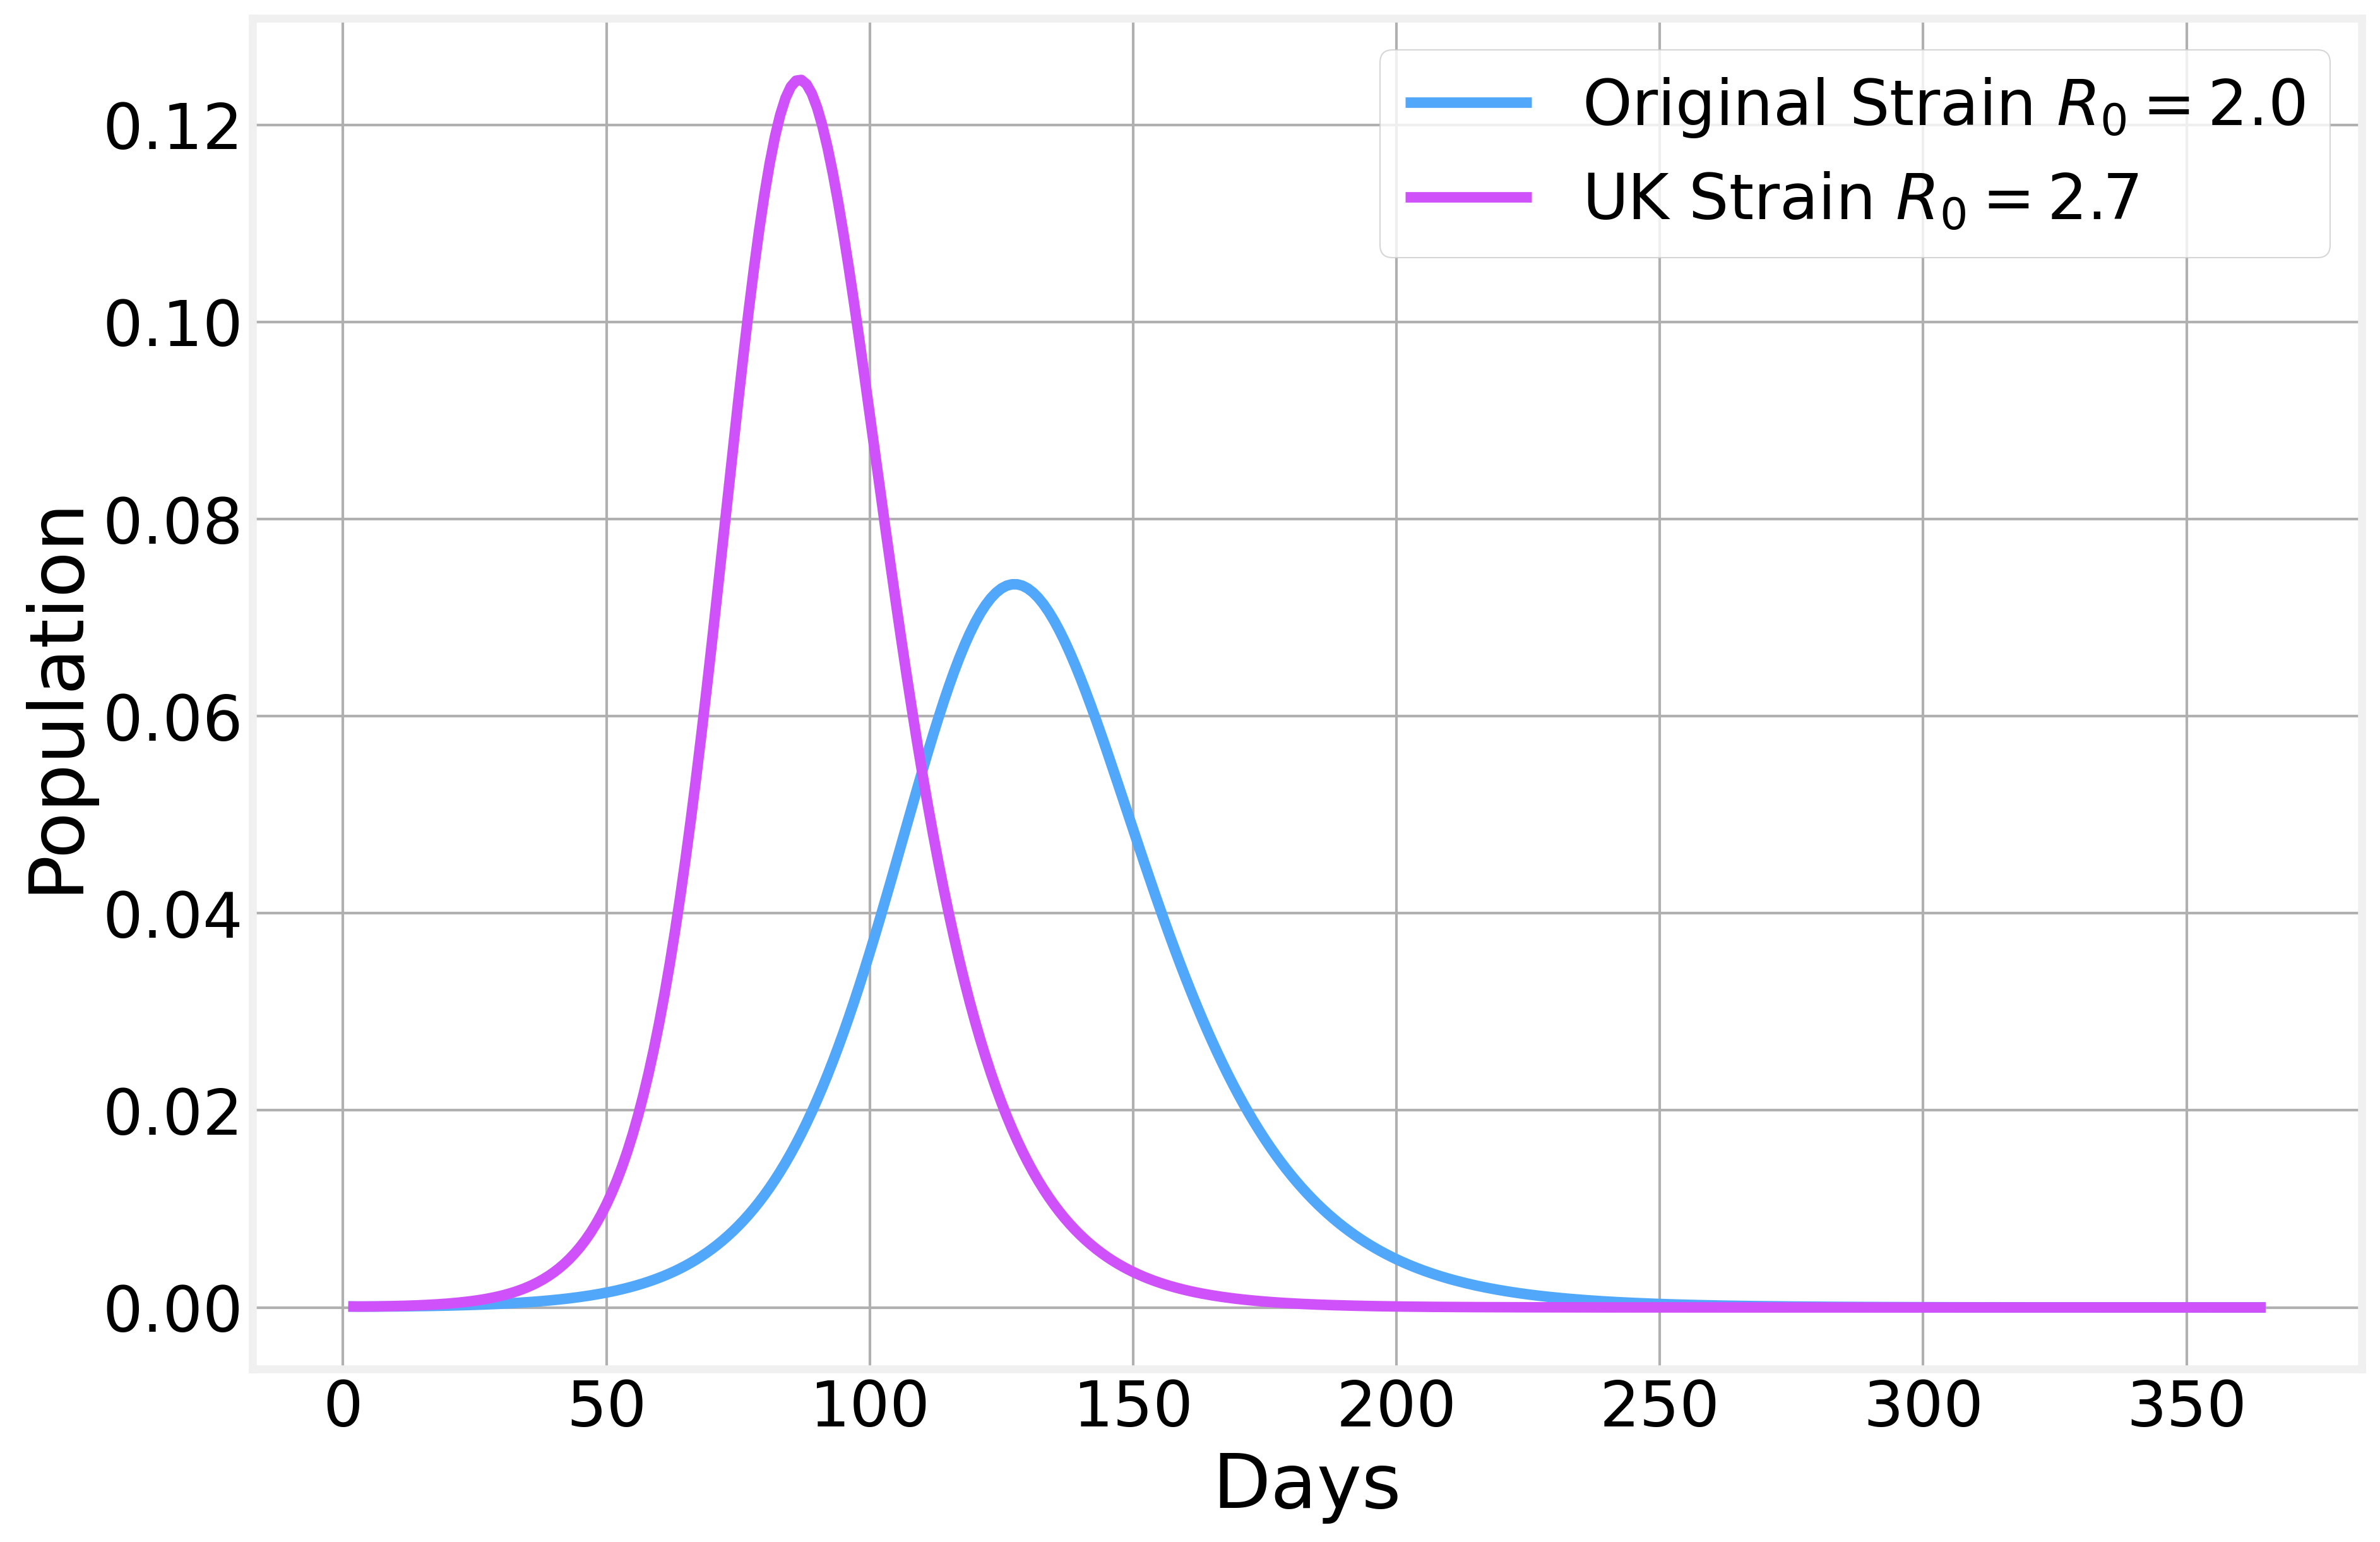

In [10]:
fig, ax = plt.subplots(1)
(original.Is/N).plot(color=colors[0], label='Original Strain $R_0=2.0$', ax=ax)
(UK.Is/N).plot(color=colors[1], label='UK Strain $R_0=2.7$', ax=ax)

ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')

## Competition

But what happens if the two strains are spreading on the same population? For this we need to modify our model by adding parallel compartments for both strains

In [11]:
mu = 0.1
pD = 0.10
rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0

betao = R0*mu/(pa*rbeta+(1-pa))
betan = (R0+0.7)*mu/(pa*rbeta+(1-pa))

SEIIRDStrain = EpiModel()
SEIIRDStrain.add_interaction('S', 'Eo', 'Iao', rbeta*betao)
SEIIRDStrain.add_interaction('S', 'Eo', 'Iso', betao)
SEIIRDStrain.add_spontaneous('Eo', 'Iao', epsilon*pa)
SEIIRDStrain.add_spontaneous('Eo', 'Iso', epsilon*(1-pa))
SEIIRDStrain.add_spontaneous('Iao', 'R', mu)
SEIIRDStrain.add_spontaneous('Iso', 'R', (1-pD)*mu)
SEIIRDStrain.add_spontaneous('Iso', 'D', pD*mu)

SEIIRDStrain.add_interaction('S', 'En', 'Ian', rbeta*betan)
SEIIRDStrain.add_interaction('S', 'En', 'Isn', betan)
SEIIRDStrain.add_spontaneous('En', 'Ian', epsilon*pa)
SEIIRDStrain.add_spontaneous('En', 'Isn', epsilon*(1-pa))
SEIIRDStrain.add_spontaneous('Ian', 'R', mu)
SEIIRDStrain.add_spontaneous('Isn', 'R', (1-pD)*mu)
SEIIRDStrain.add_spontaneous('Isn', 'D', pD*mu)

So we now have 9 compartments and 14 transitions.

In [12]:
print(SEIIRDStrain)

Epidemic Model with 9 compartments and 14 transitions:

S + Iao = Eo 0.166667
S + Iso = Eo 0.222222
S + Ian = En 0.225000
S + Isn = En 0.300000
Eo -> Iao 0.160000
Eo -> Iso 0.240000
Iao -> R 0.100000
Iso -> R 0.090000
Iso -> D 0.010000
En -> Ian 0.160000
En -> Isn 0.240000
Ian -> R 0.100000
Isn -> R 0.090000
Isn -> D 0.010000

R0=2.70


And integrating

In [13]:
N = 100000
I0o = 10
I0n = 10

In [14]:
SEIIRDStrain.integrate(365, S=N-I0o-I0n, Iao=0, Iso=I0o, Eo=0, R=0, D=0, Ian=0, Isn=I0n, En=0)
compete = SEIIRDStrain.values_.copy()

We find that the strain with the higher $R_0$ "chokes out" the original strain by reducing the pool of susceptibles 

Text(0.5, 1.0, 'Competing Strains')

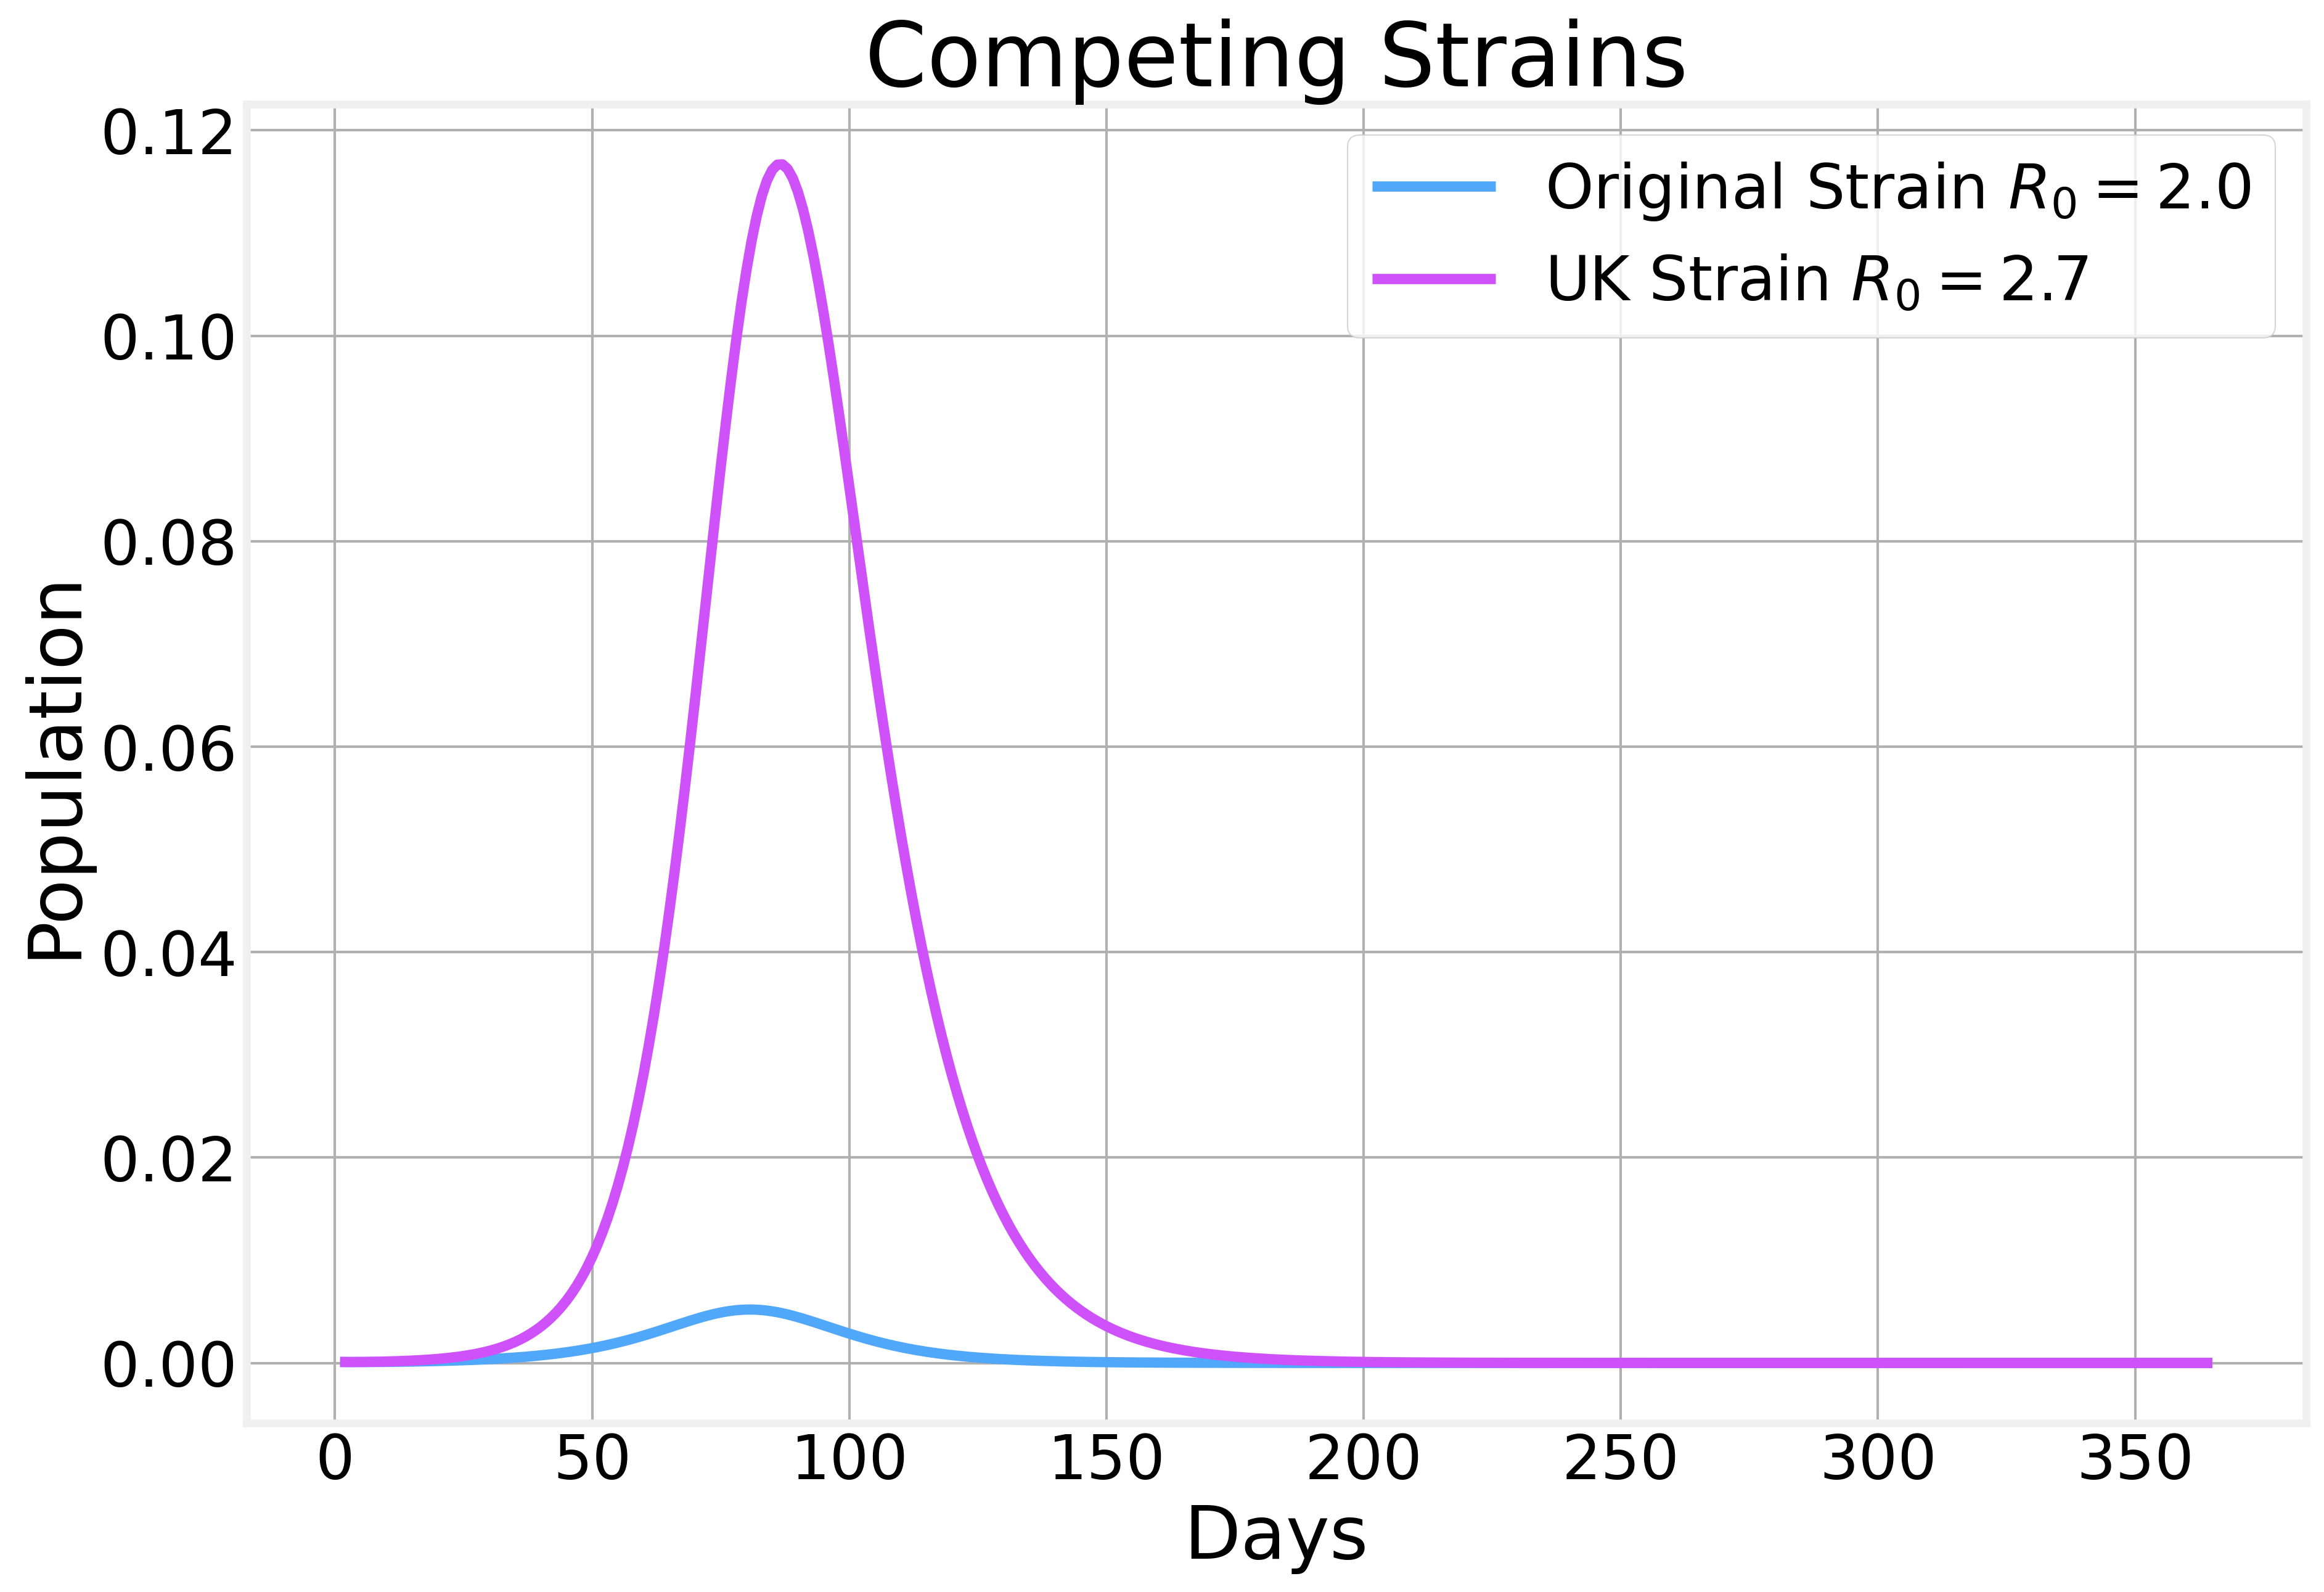

In [15]:
ax = (compete.Iso/N).plot(label='Original Strain $R_0=2.0$')
(compete.Isn/N).plot(ax=ax, label='UK Strain $R_0=2.7$')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('Competing Strains')

What if the new strain arrives when the epidemic is already on it's way so that the original strain has a head start?

In [16]:
[S, Ia, Is, E, R, D] = original.loc[50].values

We initialize our population with the compartments at time 50 from the original epidemic and just add 10 new infectious

In [17]:
SEIIRDStrain.integrate(315, S=S-I0n, Iao=Ia, Iso=Is, Eo=E, R=R, D=D,
                       Ian=0, Isn=I0n, En=0)

In [18]:
introduction = original.iloc[:49].copy()

In [19]:
SEIIRDStrain.values_.index += 49

Rename the compartments so that they match

In [20]:
introduction.rename(columns={'Ia':'Iao', 'Is': 'Iso', 'E':'Eo'}, inplace=True)

And combine the two results

In [21]:
introduction = pd.concat([introduction, SEIIRDStrain.values_]).fillna(0)

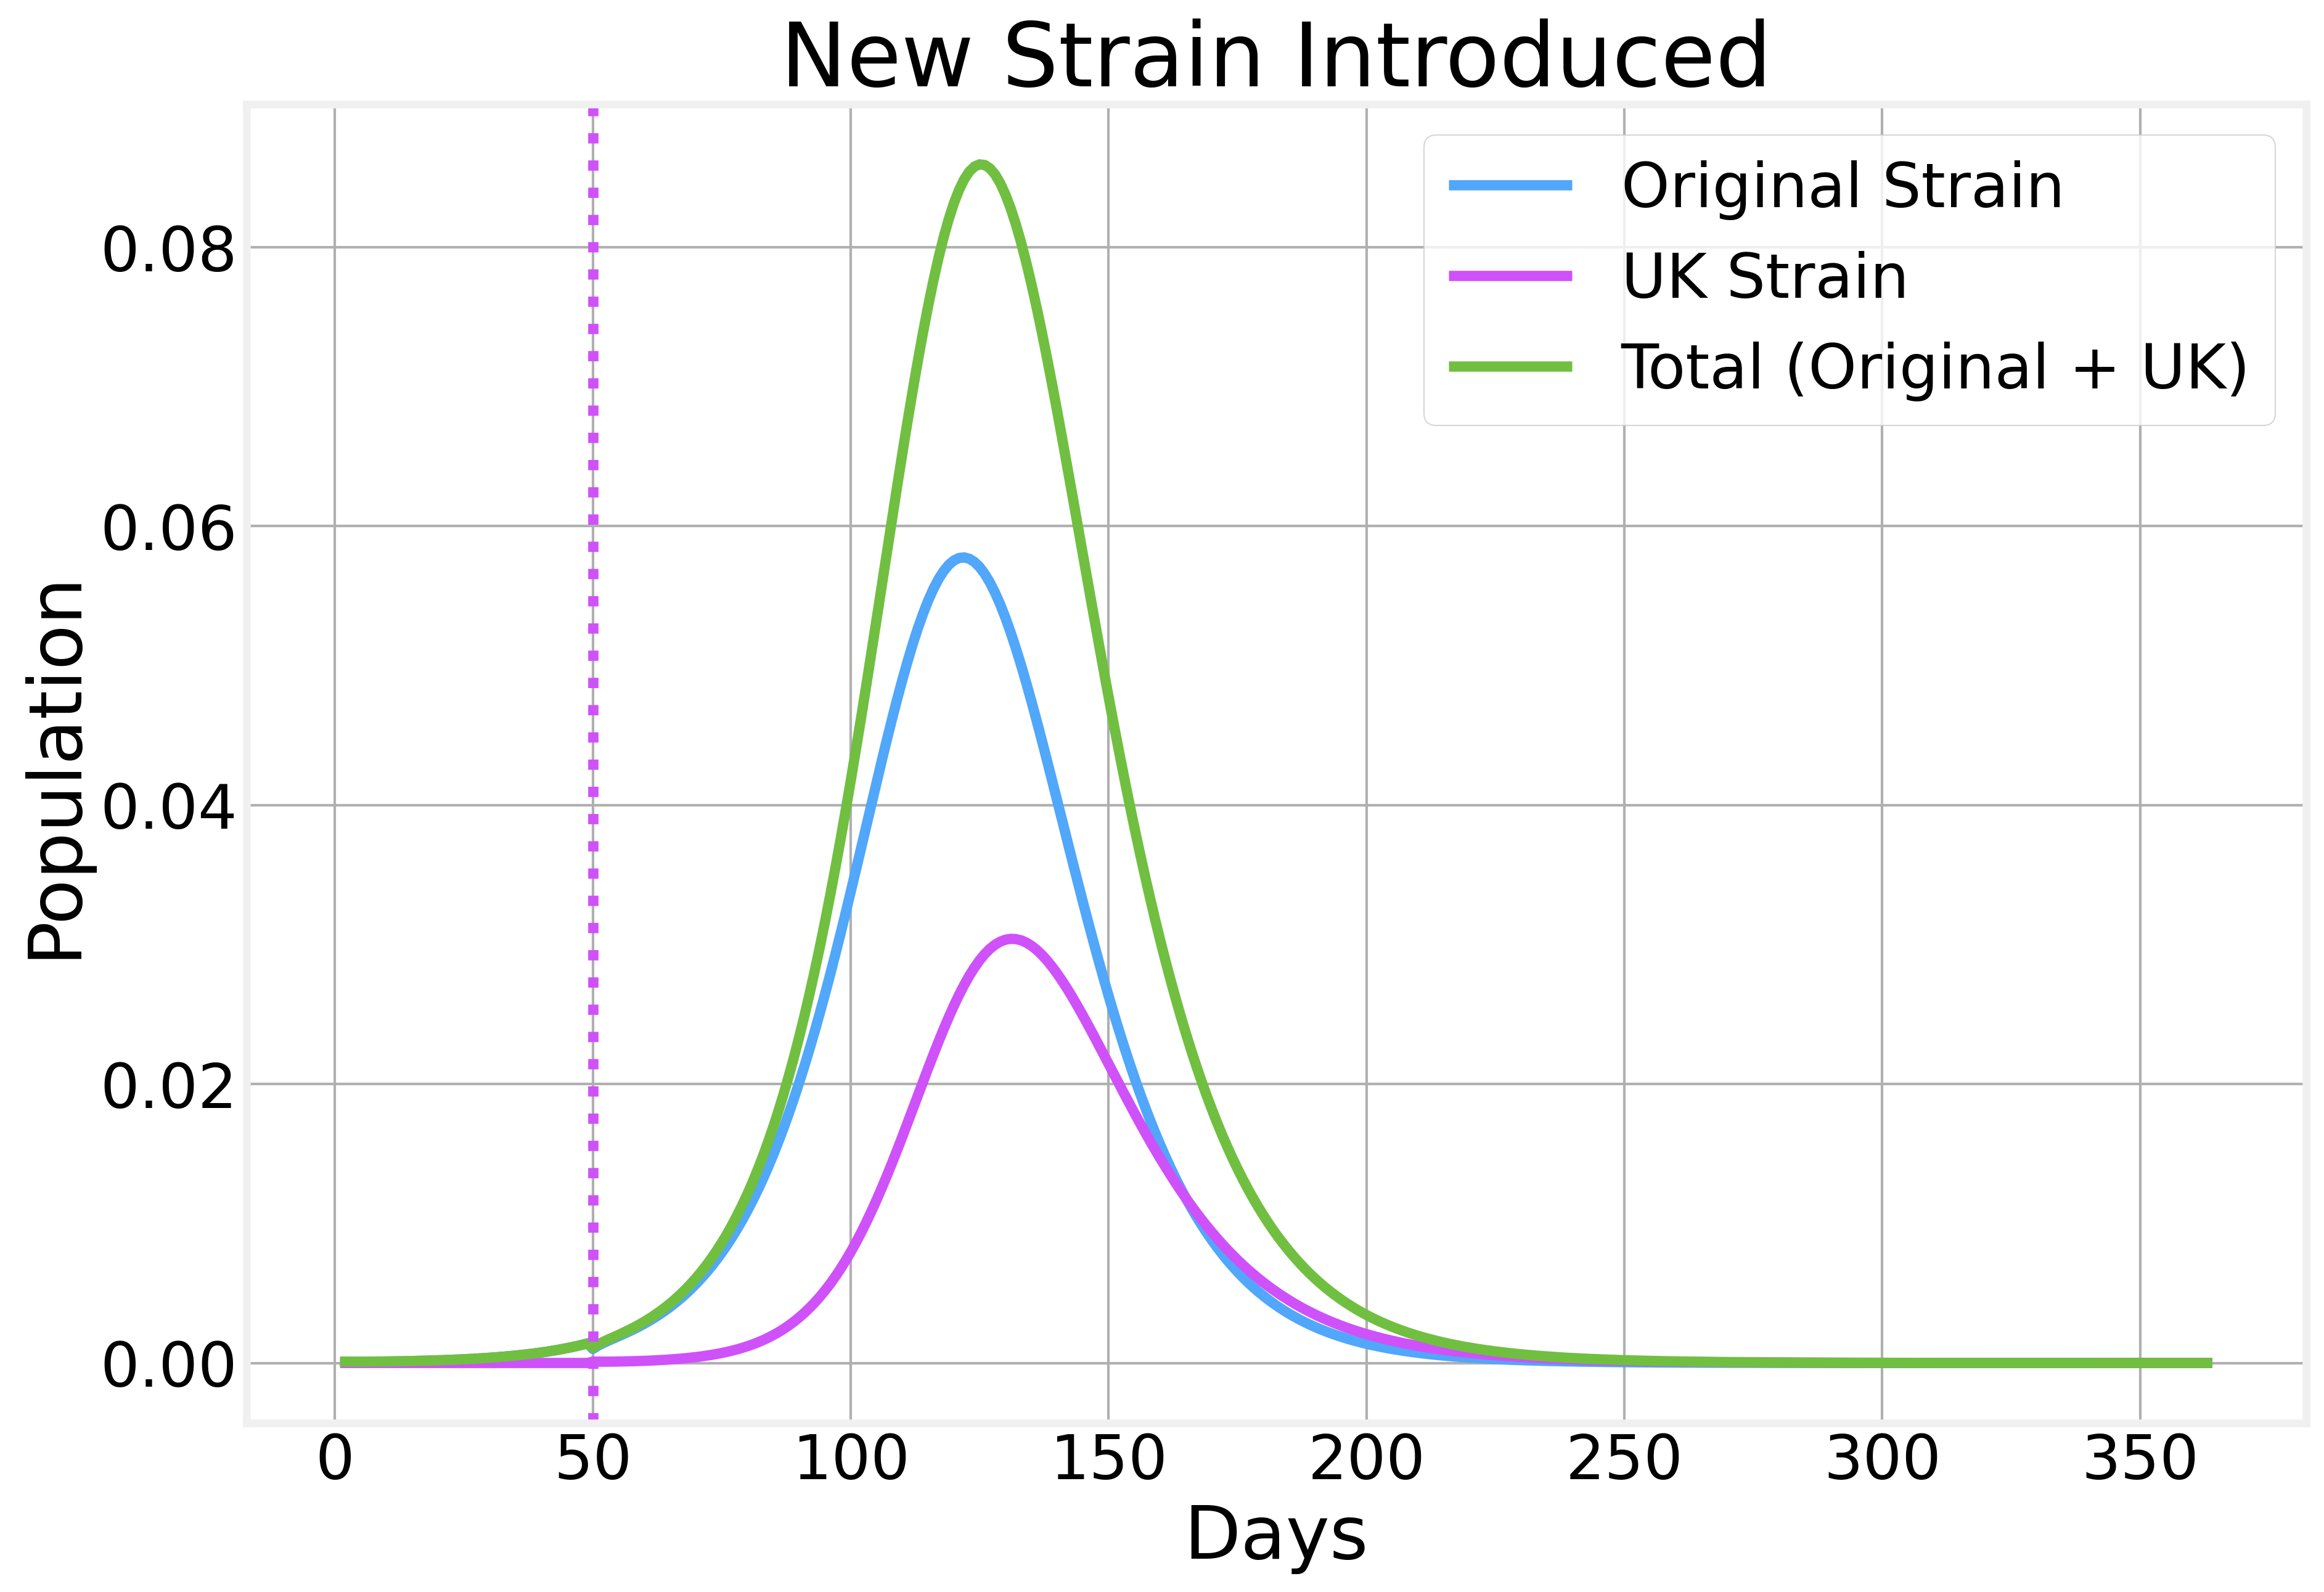

In [22]:
ax = (introduction.Iso/N).plot(label='Original Strain')
((introduction.Isn)/N).plot(ax=ax, label='UK Strain')
((introduction.Iso+introduction.Isn)/N).plot(ax=ax, label='Total (Original + UK)')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.set_title('New Strain Introduced')
ax.axvline(x=50, linestyle=':', color=colors[1])

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>